In [46]:
# импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import tarfile
import os
import time
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from random import randint
import gc
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization, Concatenate # было очень много экспериментов (оставлю на память)
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
%matplotlib inline 
ia.seed(27)

In [2]:
drive.mount('/content/drive') # подключаемся к гугл-диску, чтобы быстро забрать и разобрать наш архив с данными

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# распаковываем архив
tar_file='/content/drive/My Drive/CatsDogs/cats_dogs_dataset.tar'
z = tarfile.open(tar_file, 'r')
z.extractall(r'DogsCats') # папка , в которой будут находиться картинки
print(os.listdir()) # список строк имен файлов и подкаталогов
del z
collected = gc.collect() # подчищаем за собой, т.к. бесплатный collab не резиновый

['.config', 'drive', 'DogsCats', 'sample_data']


In [4]:
col=['class', 'xmin', 'ymin', 'xmax', 'ymax'] # имена столбцов датафрейма с рамками и классами
df_frame = pd.DataFrame(columns = col) 
dir_file = 'DogsCats'
list_file = sorted(os.listdir(dir_file)) # сортируем в буквенно-цифровом порядке. 
                                         # Фактически, т.к. картинка и соответствующая ему рамка отличаются в названии только расширением, 
                                         # то каждый текстовый файл с рамкой будет следовать за картинкой
count_txt = 0;
for file in list_file:                   # Собираем датафрейм с рамками
  if file.endswith('.txt'):
    txt = open(dir_file + '/' + file, 'r')
    l = [line.strip() for line in txt]
    df_frame=df_frame.append(pd.DataFrame([l[0].split(' ')], columns=df_frame.columns), ignore_index=True)
    count_txt+=1
    txt.close()
print("Количество текстовых файлов =", count_txt) # счетчик рамок
del count_txt, txt,l
collected = gc.collect()

Количество текстовых файлов = 3385


In [5]:
df_frame.head()

,class,xmin,ymin,xmax,ymax
0,1,333,72,425,158
1,1,72,105,288,291
2,1,151,71,335,267
3,1,54,36,319,235
4,1,23,27,325,320


In [6]:
df_frame.describe() #  2 класса, маленькая выборка - а значит нужна аугментация

,class,xmin,ymin,xmax,ymax
count,3385,3385,3385,3385,3385
unique,2,358,237,422,383
top,2,1,1,319,236
freq,2348,49,239,27,24


In [7]:
df_frame['class'].value_counts() # как видно ниже - классы несбалансированы

2    2348
1    1037
Name: class, dtype: int64

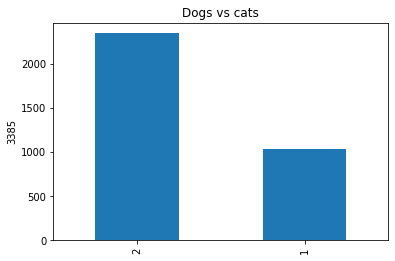

In [8]:
df_frame['class'].value_counts().plot.bar()
plt.title('Dogs vs cats')
plt.ylabel(len(df_frame))
plt.show()

In [9]:
images_cats=[]
images_dogs=[]
bbs_list=[]
i=0
# достаём картинки для каждого класса
for filename in list_file: 
  if filename.endswith('.jpg') and df_frame['class'][i]=='1':
     im=imageio.imread(dir_file + '/' + filename)
     images_cats.append(im)
     i+=1
  elif filename.endswith('.jpg') and df_frame['class'][i]=='2':
     im=imageio.imread(dir_file + '/' + filename)
     images_dogs.append(im)
     i+=1

In [10]:
len(images_cats)

1037

In [11]:
# каждому животному по рамке. собираем датафреймы по классам
df_frame_cats=df_frame.loc[df_frame['class'] == '1'].copy(deep=True)
df_frame_dogs=df_frame.loc[df_frame['class'] == '2'].copy(deep=True)
df_frame_cats.reset_index(drop=True, inplace=True)
df_frame_dogs.reset_index(drop=True, inplace=True)
df_frame_dogs

,class,xmin,ymin,xmax,ymax
0,2,103,47,330,268
1,2,204,105,290,202
2,2,168,35,319,178
3,2,156,89,248,192
4,2,126,119,237,226
...,...,...,...,...,...
2343,2,208,32,356,231
2344,2,187,49,317,181
2345,2,94,36,378,263
2346,2,274,84,402,207


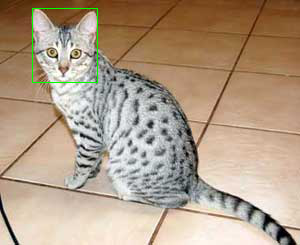

In [12]:
def box_on_image(images,dataframe,i):  # функция для отрисовки рамки на картинке
    img1=images[i]
    x_min=float(dataframe.xmin[i])
    y_min=float(dataframe.ymin[i])
    x_max=float(dataframe.xmax[i])
    y_max=float(dataframe.ymax[i])
    bbs = BoundingBoxesOnImage([BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max)], shape=img1.shape)
    img1 = bbs.draw_on_image(img1,size=1)
    return img1
    
img1 = Image.fromarray(box_on_image(images_cats,df_frame_cats,500))
img1

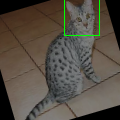

In [13]:
seq=iaa.Sequential([               #Наш аугментор
                    iaa.Resize({'height': 120, 'width': 120}), #приведём изображения к одному размеру
                    iaa.Fliplr(0.5), # будем случайно отражать изображение
                    iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)), # будем изменять контрастность (изменять градиент, а значит изменять веса тех или иных границ объектов на изображении)
                    iaa.Add((-40, 40)), # будеи добавлять случайное постоянное значение к пикселям изображения
                    iaa.Multiply((0.5, 1.5), per_channel=0.5), # будем умножать значение каждого пикселя на некторое число
                    iaa.Invert(0.25, per_channel=0.5), # будем случайно инвертировать цвета
                    iaa.Affine(rotate=(-20, 20)) # будем немного поворачивать изображение
                    ])

def seq_box_and_image(seq,images,dataframe,i): # функция для применения аугментора к рамке и изображению
    img1=images[i]
    x_min=float(dataframe.xmin[i])
    y_min=float(dataframe.ymin[i])
    x_max=float(dataframe.xmax[i])
    y_max=float(dataframe.ymax[i])
    bbs = BoundingBoxesOnImage([BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max)], shape=img1.shape)
    image_aug, bbs_aug = seq(image=img1, bounding_boxes=bbs)
    return image_aug, bbs_aug

# тестируем функцию
image_aug, bbs_aug=seq_box_and_image(seq,images_cats,df_frame_cats,500)
df_test = pd.DataFrame(columns = col)
df_test=df_test.append(pd.DataFrame([['1',bbs_aug.bounding_boxes[0].x1,bbs_aug.bounding_boxes[0].y1,bbs_aug.bounding_boxes[0].x2,bbs_aug.bounding_boxes[0].y2]], columns=col), ignore_index=True)
img1 = Image.fromarray(box_on_image([image_aug],df_test,0))
img1

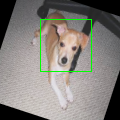

In [14]:
image_aug, bbs_aug=seq_box_and_image(seq,images_dogs,df_frame_dogs,500)
df_test = pd.DataFrame(columns = col)
df_test=df_test.append(pd.DataFrame([['1',bbs_aug.bounding_boxes[0].x1,bbs_aug.bounding_boxes[0].y1,bbs_aug.bounding_boxes[0].x2,bbs_aug.bounding_boxes[0].y2]], columns=col), ignore_index=True)
img1 = Image.fromarray(box_on_image([image_aug],df_test,0))
img1

In [15]:
res=iaa.Sequential([iaa.Resize({'height': 120, 'width': 120})]) # вспомогательный аугментор для быстрого ресайза рамки и изображения

# препроцессинг всех изображений и рамок. собираем в списки исходные и аугментированные изображения, применяем res к исходным картинкам, применяем аугментацию к рамкам
# приводим координаты рамок к относительным
df_aug_dogs=pd.DataFrame(columns = col)
df_aug_cats=pd.DataFrame(columns = col)
images_aug_cats=[]
images_aug_dogs=[]

for i in range(0,len(df_frame_dogs)):
  image_aug, bbs_aug=seq_box_and_image(res,images_dogs,df_frame_dogs,i)
  list_aug_dogs=[2,bbs_aug.bounding_boxes[0].x1/image_aug.shape[0],bbs_aug.bounding_boxes[0].y1/image_aug.shape[1],bbs_aug.bounding_boxes[0].x2/image_aug.shape[0],bbs_aug.bounding_boxes[0].y2/image_aug.shape[1]]
  df_aug_dogs=df_aug_dogs.append(pd.DataFrame([list_aug_dogs], columns=col), ignore_index=True)
  images_aug_dogs.append(np.array(Image.fromarray(image_aug).convert('RGB')))

for i in range(0,len(df_frame_cats)):
  image_aug, bbs_aug=seq_box_and_image(res,images_cats,df_frame_cats,i)
  list_aug_cats=[1,bbs_aug.bounding_boxes[0].x1/image_aug.shape[0],bbs_aug.bounding_boxes[0].y1/image_aug.shape[1],bbs_aug.bounding_boxes[0].x2/image_aug.shape[0],bbs_aug.bounding_boxes[0].y2/image_aug.shape[1]]
  df_aug_cats=df_aug_cats.append(pd.DataFrame([list_aug_cats], columns=col), ignore_index=True)
  images_aug_cats.append(np.array(Image.fromarray(image_aug).convert('RGB')))

df_aug_dogs=df_aug_dogs.applymap(float)
df_aug_dogs['class']=df_aug_dogs['class'].apply(int)

df_aug_cats=df_aug_cats.applymap(float)
df_aug_cats['class']=df_aug_cats['class'].apply(int)

count_dogs=df_aug_dogs.shape[0]
count_cats=df_aug_cats.shape[0]
index_dogs=0
index_cats=0
value_animals=10000

while min(count_dogs,count_cats)!=value_animals:
  if count_cats!=value_animals:
    image_aug, bbs_aug=seq_box_and_image(seq,images_cats,df_frame_cats,index_cats)
    list_aug_cats=[1,bbs_aug.bounding_boxes[0].x1/image_aug.shape[0],bbs_aug.bounding_boxes[0].y1/image_aug.shape[1],bbs_aug.bounding_boxes[0].x2/image_aug.shape[0],bbs_aug.bounding_boxes[0].y2/image_aug.shape[1]]
    df_aug_cats=df_aug_cats.append(pd.DataFrame([list_aug_cats], columns=col), ignore_index=True)
    images_aug_cats.append(np.array(Image.fromarray(image_aug).convert('RGB')))
    count_cats+=1
    index_cats+=1
    if index_cats>len(images_cats)-1:
      index_cats=index_cats-len(images_cats)+1
  
  if count_dogs!=value_animals:
    image_aug, bbs_aug=seq_box_and_image(seq,images_dogs,df_frame_dogs,index_dogs)
    list_aug_dogs=[2,bbs_aug.bounding_boxes[0].x1/image_aug.shape[0],bbs_aug.bounding_boxes[0].y1/image_aug.shape[1],bbs_aug.bounding_boxes[0].x2/image_aug.shape[0],bbs_aug.bounding_boxes[0].y2/image_aug.shape[1]]
    df_aug_dogs=df_aug_dogs.append(pd.DataFrame([list_aug_dogs], columns=col), ignore_index=True)
    images_aug_dogs.append(np.array(Image.fromarray(image_aug).convert('RGB')))
    count_dogs+=1
    index_dogs+=1
    if index_dogs>len(images_dogs)-1:
      index_dogs=index_dogs-len(images_dogs)+1

In [16]:
del df_test, list_aug_cats,list_aug_dogs,images_cats,images_dogs,df_frame_cats,df_frame_dogs,df_frame,seq
collected = gc.collect()

In [17]:
# видим , что теперь количество объектов стало достаточным
print('Dogs:')
print(df_aug_dogs.describe())
print('')
print('Cats:')
print(df_aug_cats.describe())

Dogs:
         class          xmin          ymin          xmax          ymax
count  10000.0  10000.000000  10000.000000  10000.000000  10000.000000
mean       2.0      0.257188      0.133543      0.731814      0.633981
std        0.0      0.153887      0.126713      0.154320      0.167475
min        2.0     -0.137780     -0.138754      0.219566      0.210000
25%        2.0      0.147905      0.036944      0.629475      0.510290
50%        2.0      0.254750      0.112982      0.735043      0.613614
75%        2.0      0.360309      0.209794      0.841621      0.746686
max        2.0      0.776000      0.676615      1.132427      1.133505

Cats:
         class          xmin          ymin          xmax          ymax
count  10000.0  10000.000000  10000.000000  10000.000000  10000.000000
mean       1.0      0.268254      0.099073      0.725357      0.589799
std        0.0      0.173007      0.111444      0.173991      0.166118
min        1.0     -0.139942     -0.135622      0.155814      0.

In [18]:
print('Число картинок с котами: ',len(images_aug_cats))
print('Число картинок с пёсиками: ',len(images_aug_dogs))

Число картинок с котами:  10000
Число картинок с пёсиками:  10000


In [19]:
# объединяем
df_animals=pd.concat([df_aug_cats,df_aug_dogs],ignore_index=True) 
img_animals=images_aug_cats+images_aug_dogs
df_animals

,class,xmin,ymin,xmax,ymax
0,1,0.555000,0.180000,0.708333,0.395000
1,1,0.192000,0.210000,0.768000,0.582000
2,1,0.383249,0.142000,0.850254,0.534000
3,1,0.120000,0.115016,0.708889,0.750799
4,1,0.046000,0.058065,0.650000,0.688172
...,...,...,...,...,...
19995,2,0.264200,-0.021449,1.099298,0.607792
19996,2,0.503226,0.163611,0.739259,0.396146
19997,2,0.334092,0.234748,0.665473,0.674042
19998,2,0.118201,0.267036,0.943027,1.009500


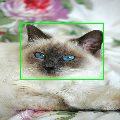

In [20]:
def box_on_image_proc(images,dataframe,i): # модернизированная box_on_image с относительными координатами
    img1=images[i]
    x_min=float(dataframe.xmin[i])*img1.shape[0]
    y_min=float(dataframe.ymin[i])*img1.shape[1]
    x_max=float(dataframe.xmax[i])*img1.shape[0]
    y_max=float(dataframe.ymax[i])*img1.shape[1]
    bbs = BoundingBoxesOnImage([BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max)], shape=img1.shape)
    img1 = bbs.draw_on_image(img1,size=1)
    return img1

img1 = Image.fromarray(box_on_image_proc(img_animals,df_animals,randint(0,df_animals.shape[0]-1)))
img1

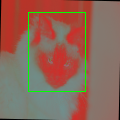

In [21]:
df_animals['img']=img_animals
del img_animals
collected = gc.collect()
df_animals = df_animals.sample(frac=1).reset_index(drop=True) 
img_animals=df_animals['img'].to_list()
df_animals=df_animals.drop(['img'], axis=1)
img1 = Image.fromarray(box_on_image_proc(img_animals,df_animals,randint(0,df_animals.shape[0]-1)))
img1

In [22]:
# преобразуем классы, чтобы binary_crossentropy считала адекватно
df_animals.loc[df_animals['class'] == 1 ,'class'] = 0
df_animals.loc[df_animals['class'] == 2 ,'class'] = 1
df_animals

,class,xmin,ymin,xmax,ymax
0,0,0.303379,0.299620,0.474870,0.507451
1,0,0.356961,0.143104,0.806896,0.478842
2,1,0.624625,0.260000,0.945946,0.408000
3,1,0.070000,0.057143,0.836667,0.789286
4,0,0.153257,-0.047167,1.104311,0.919610
...,...,...,...,...,...
19995,1,0.163927,0.024138,0.835882,0.624872
19996,1,0.570671,0.323485,0.808494,0.556899
19997,0,0.268249,0.051631,0.995311,0.804440
19998,1,0.427567,0.153311,0.660419,0.501271


In [30]:
gc.disable()

# строим модель
img_animals=np.array(img_animals)
X_train, X_test, y_train, y_test = train_test_split(img_animals, df_animals, test_size=0.2, random_state=27) # делим на тренировочную и валидационную выборки

y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001,   # вместо val_acc можно отслеживать точность по любому выходу на валидационной выборке, чтобы вовремя остановить обучение
                           patience=10, verbose=1, mode='auto')
chkpt = ModelCheckpoint('modelDC',    # сохраняем лучший результат модели
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='auto')

callbacks = [early_stop, chkpt]

def model_create(X_train):

  inputs = Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))

  x = Conv2D(24, 3, activation='relu')(inputs)
  x = MaxPooling2D(2,2)(x)
  x = Conv2D(48, 3, activation='relu')(x)
  x = MaxPooling2D(2,2)(x)
  x = Conv2D(120, 3, activation='relu')(x)
  x = BatchNormalization()(x) # после нормализации можно не делать часто дропаут, с дропаутом работает хуже
  x = MaxPooling2D(2,2)(x)
  x = Conv2D(120, 3, activation='relu')(x) #
  x = BatchNormalization()(x) #
  x = MaxPooling2D(2,2)(x) #
  x = Flatten()(x)
  x = Dropout(0.5)(x) # большой дропаут, потому что всё-таки генерация была из маленькой выборки
  x = Dense(240, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x) # дропаут между полносвязеыми слоями от переобучения
  x = Dense(480, activation='relu')(x)
  x = Dropout(0.25)(x)
  y = Dense(120, activation='relu')(x)
  x = Dropout(0.25)(x)
  classifier = Dense(1, activation='sigmoid')(x)  # два класса, поэтому сигмоида
  regression = Dense(4, activation='linear')(y) # слой для регрессии

  mdl = Model(inputs=inputs, outputs=[classifier, regression]) # собираем модель с двумя выходами
  mdl.summary()

  mdl.compile(optimizer=Adam(0.001),                      # для увеличения точности и скорости обучения можно менять скорость в callbacks, но здесь это не реализованно      
                  loss=['binary_crossentropy','mse'],                                  
                 metrics=['accuracy'],
              experimental_run_tf_function=False) 

  return mdl

model=model_create(X_train)
history_training=model.fit(X_train,[y_train['class'],y_train.iloc[:,1:5]],batch_size=50, epochs=30, validation_data=(X_test, [y_test['class'],y_test.iloc[:,1:5]]), verbose=1, callbacks=callbacks)

#эпох можно было сделать больше, но после 30 целевые параметры меняются медленно, данный подход отвергнут в пользу экономии времени



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 118, 118, 24) 672         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 59, 59, 24)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 57, 57, 48)   10416       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.72016, saving model to modelDC
INFO:tensorflow:Assets written to: modelDC/assets
16000/16000 [==============================] - 364s 23ms/sample - loss: 0.8651 - dense_28_loss: 0.7796 - dense_29_loss: 0.0855 - dense_28_accuracy: 0.5466 - dense_29_accuracy: 0.6324 - val_loss: 0.7202 - val_dense_28_loss: 0.6701 - val_dense_29_loss: 0.0500 - val_dense_28_accuracy: 0.5813 - val_dense_29_accuracy: 0.7330
Epoch 2/30
16000/16000 [==============================] - ETA: 0s - loss: 0.7054 - dense_28_loss: 0.6769 - dense_29_loss: 0.0285 - dense_28_accuracy: 0.5954 - dense_29_accuracy: 0.7344WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,dense_28_loss,dense_29_loss,dense_28_accuracy,dense_29_accuracy,val_loss,val_dense_28_loss,val_dense_29_loss,val_dense_28_accuracy,val_dense_29_accuracy

Epoch 00002: val_loss improved from 0.72016 to 0.68151, saving model to modelDC
INFO:tensorflow

In [33]:
model = load_model('modelDC') # загружаем модель

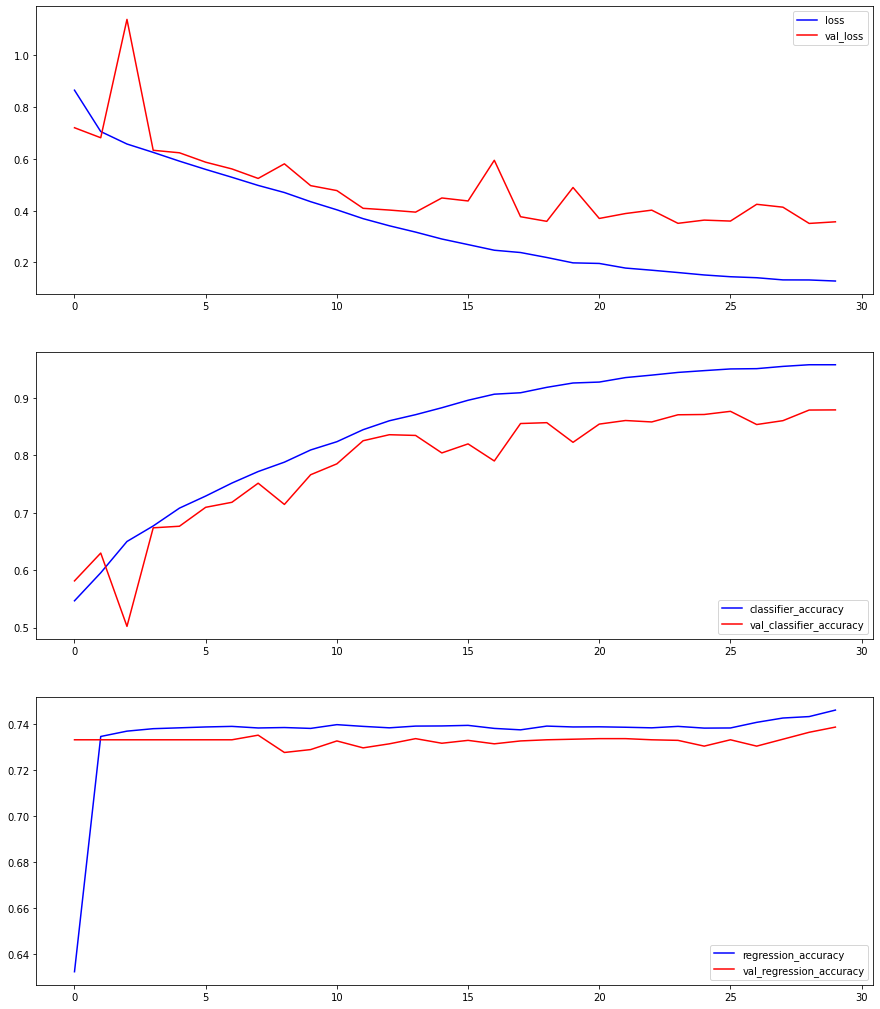

In [36]:
# строим графики
fig = plt.figure(figsize=(15, 18))

sp1= fig.add_subplot(311)
sp2= fig.add_subplot(312)
sp3= fig.add_subplot(313)

x = range(30)

sp1.plot(x, history_training.history['loss'], 'b-', label='loss')
sp1.plot(x, history_training.history['val_loss'], 'r-', label='val_loss')
sp1.legend(loc='upper right')

sp2.plot(x, history_training.history['dense_28_accuracy'], 'b-', label='classifier_accuracy')
sp2.plot(x, history_training.history['val_dense_28_accuracy'], 'r-', label='val_classifier_accuracy')
sp2.legend(loc='lower right')

sp3.plot(x, history_training.history['dense_29_accuracy'], 'b-', label='regression_accuracy')
sp3.plot(x, history_training.history['val_dense_29_accuracy'], 'r-', label='val_regression_accuracy')
sp3.legend(loc='lower right')


In [63]:
# смотрим accuracy
predict_class, predict_frame = model.predict(X_test)

all_class = []
for i in range(predict_class.shape[0]):
  if predict_class[i] < 0.5:
    one_class = 0
  else:
    one_class = 1
  all_class.append(one_class)
y_model_test = pd.DataFrame(all_class)

acc = accuracy_score(y_test['class'], y_model_test) * 100
print('Accuracy (classifier): ',acc)

Accuracy (classifier):  87.9


In [57]:
# вычисляем mIoU
# https://habr.com/ru/company/directum/blog/486476/
def bb_intersection_over_union(a, b):
   # Координаты заданы в виде верхнего левого и правого нижнего угла прямоугольника.
   # 0 - координата X для верхнего левого угла,
   # 1 - координата Y для верхнего левого угла,
   # 2 - координата X для правого нижнего угла,
   # 3 - координата Y для правого нижнего угла.
   x_a = max(a[0], b[0])
   y_a = max(a[1], b[1])
   x_b = min(a[2], b[2])
   y_b = min(a[3], b[3])

   # Площадь пересечения.
   inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

   # Площади прямоугольников.
   a_area = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
   b_area = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)

   # Intersection over Union.
   iou = inter_area / float(a_area + b_area - inter_area)

   return iou

# усредняем IOU
all_IOU=[]
for i in range(predict_frame.shape[0]):
  one_IOU=bb_intersection_over_union(predict_frame[i],y_test.iloc[i,1:5])
  all_IOU.append(one_IOU)
mIOU=np.mean(all_IOU)*100
print('mIOU: ',mIOU)

mIOU:  76.26898745551539


In [58]:
# сохраняем
js_model=model.to_json()
with open ("model_CatDog.json","w") as js:
  js.write(js_model)
model.save_weights("model_CatDog.h5")

Это всё-таки кот!


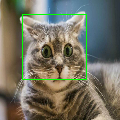

In [121]:
# проверяем на своём коте
im=imageio.imread('/content/drive/My Drive/test_cat.jpg')
img= np.array([res(image=im)])

start_time = time.time() #считаем inference
self_identification, cat_frame = model.predict(img)
end_time=(time.time() - start_time)

df_frame_this_cat = pd.DataFrame(columns = col)
df_frame_this_cat=df_frame_this_cat.append(pd.DataFrame([[self_identification[0][0],cat_frame[0][0],cat_frame[0][1],cat_frame[0][2],cat_frame[0][3]]], columns=df_frame_this_cat.columns), ignore_index=True)

if self_identification < 0.5:
  print('Это всё-таки кот!')
else:
  print('Увы, но это пёс')

img1 = Image.fromarray(box_on_image_proc(img,df_frame_this_cat,0))
img1

In [123]:
# рассказываем, что получилось
print('mIOU: ',round(mIOU,2), '%')
print('classification accuracy: ',round(acc,2) ,'%')
print('Inference:', round(end_time,3), 'seconds')
print(X_train.shape[0],'train')
print(X_test.shape[0],'valid')

mIOU:  76.27 %
classification accuracy:  87.9 %
Inference: 0.013 seconds
16000 train
4000 valid
